In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from fna.tools.signals import make_simple_kernel, pad_array

import os
import sys
import re
import sys

import pickle

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


In [4]:
sys.path.append("../../demyelination/") # we need this to successfully read pickle files
sys.path.append("../../") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully import the pipeline

In [5]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'MGN']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

In [7]:
def readnet_timeinterval(exp_name, time_interval, stop_time, nthreads=8, parameter_file=None):
    dfs = []
    record_times = [0] + list( range(time_interval, stop_time, time_interval) )

    for t in record_times:
        if parameter_file == None:
            dump_filename = '../../demyelination/data/' + exp_name + '/other/' + str(t) + '.0_net_{threadid}'
        else:
            dump_filename = '../../demyelination/data/' + exp_name + '/other/' + parameter_file + '{threadid}' + '/' + str(t) + '.0_net_{threadid}'

        df = pd.DataFrame()

        for threadid in range(nthreads):
            with open(dump_filename.format(threadid=threadid), "rb") as f:
                network = pickle.load(f)

                net = network['synapse_ex']
                #print(net.shape)

                df = pd.concat([df, net])
        dfs.append(df)
    return dfs

In [18]:
import networkx as nx
from networkx.algorithms import bipartite

In [19]:
def plotConnectionGraph (conn_df, ax):
    g = nx.Graph()

    max_height_plot = len( conn_df.target.unique() ) # the graph must be the height of eaone neurons
    mgn_node_space = max_height_plot / len( conn_df.source.unique() ) 

    pos = {}
    pos.update( (n, (1, idx*mgn_node_space)) for idx, n in enumerate( np.sort( conn_df.source.unique() ) ) )

    pos.update( (n, (2, idx)) for idx, n in enumerate( np.sort( conn_df.target.unique() ) ) )

    mgn_nodes = conn_df.source.unique()
    g.add_nodes_from(mgn_nodes)

    eaone_nodes = conn_df.target.unique()
    g.add_nodes_from(eaone_nodes)
    
    # adding edges with weight 4
    wfour = conn_df[conn_df.weight == 4]
    for src, tgt in zip (wfour.source, wfour.target):
        # if the connection was predefined and not grown
        if (
            (src in range(1, 41) and tgt in range(401, 801)) |
            (src in range(41, 81) and tgt in range(801, 1201)) |
            (src in range(81, 121) and tgt in range(1201, 1601)) |
            (src in range(121, 161) and tgt in range(1601, 2001)) |
            (src in range(161, 201) and tgt in range(2001, 2401))
        ):
            g.add_edge(src, tgt, color='r')
        else:
            g.add_edge(src, tgt, color='b')
    
    # adding edges with weight 0
    wzero = conn_df[conn_df.weight == 0]
    for src, tgt in zip (wzero.source, wzero.target):
        g.add_edge(src, tgt, color='k')
    
    colors = nx.get_edge_attributes(g,'color').values()
    
    nx.draw_networkx(g, pos = pos, ax=ax, node_size=10, with_labels=False, linewidths=.001, alpha=.01, edge_color=colors)

In [24]:
perc_mgn_eA1

array([0.0079025, 0.0079025, 0.008675 , 0.0095525, 0.0103175, 0.0109925,
       0.011605 , 0.0121725, 0.0126525, 0.013075 , 0.01345  , 0.013775 ,
       0.0140225, 0.0142675, 0.0145425, 0.014775 , 0.0149775])

In [25]:
recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

KeyError: 'eA1'

ValueError: x and y must have same first dimension, but have shapes (11,) and (17,)

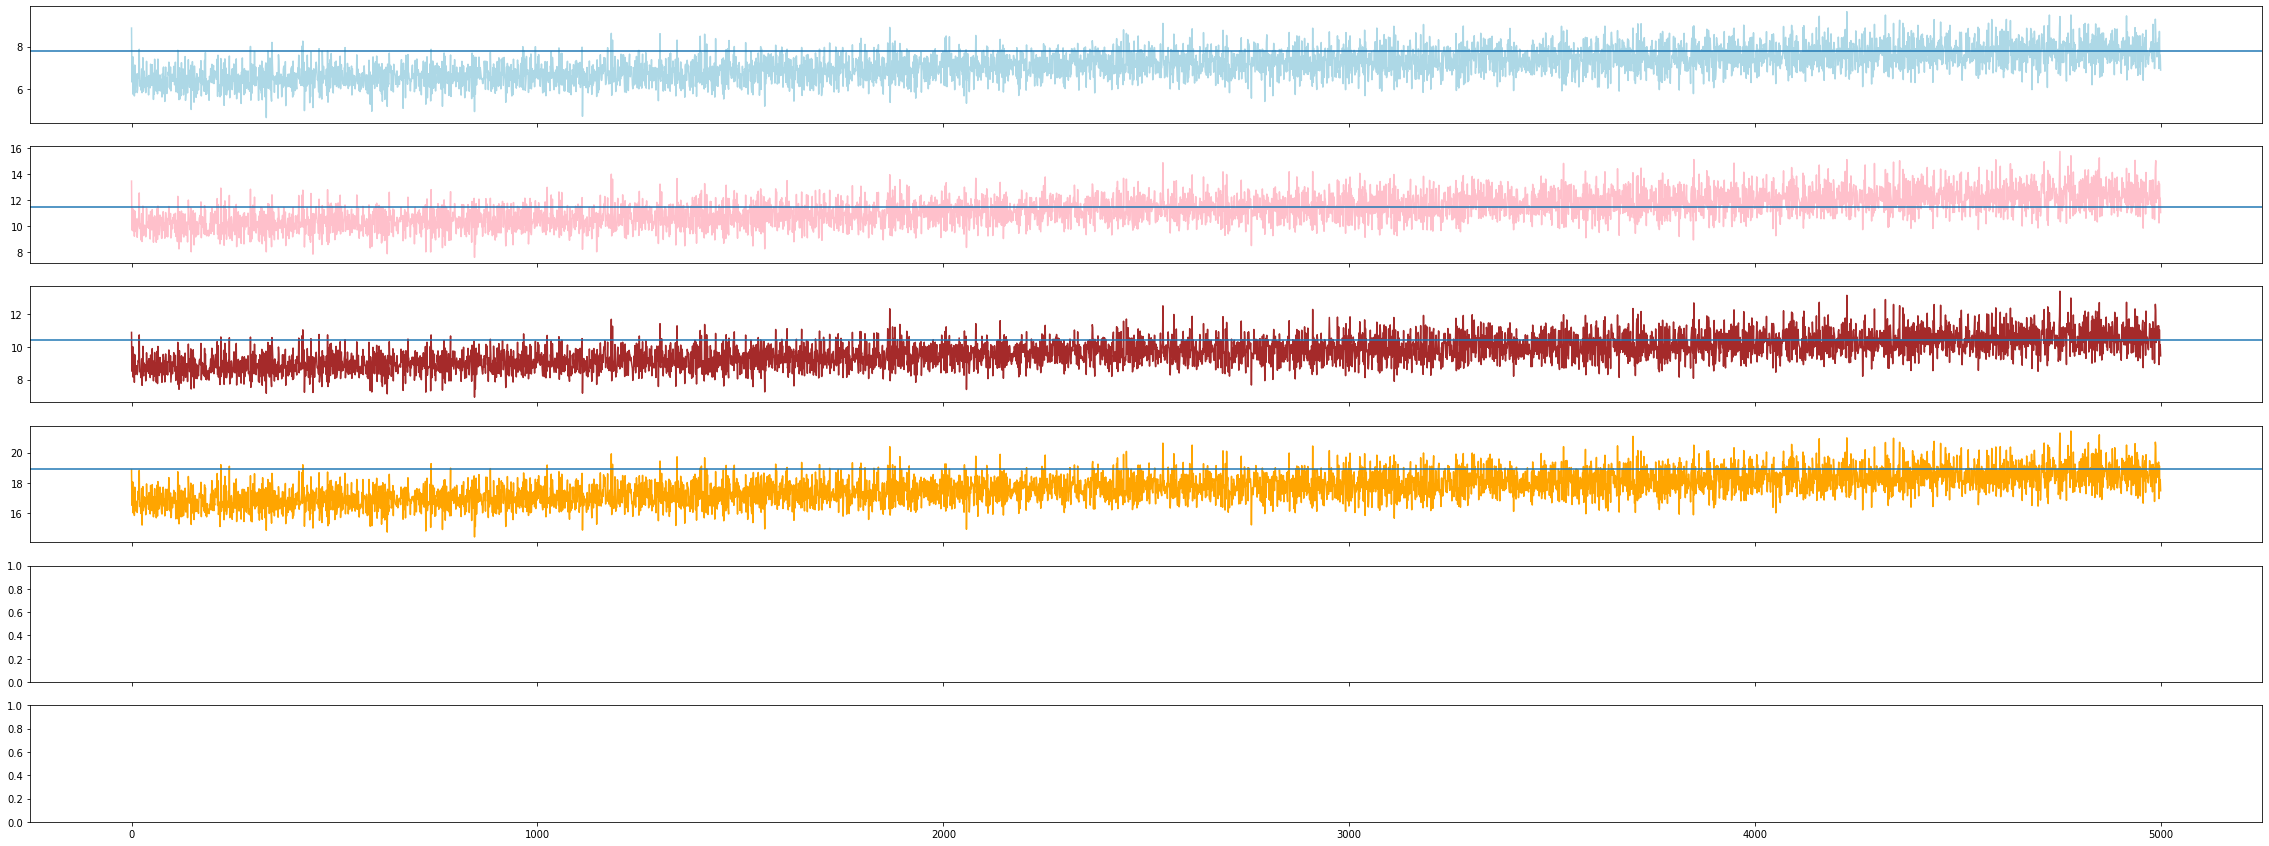

In [21]:
exp_name = '20pcdemy-15000s-eaone-doublerecurrgrowth'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_disabled_conn_ratio=0.2_gr_scale=1e-05_update_interval=50_"

nthread = 4

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

# DendriteType_Population
perc_mgn_eA1 = np.divide(ex_eA1, 2000*200)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(40, 15)

tstart = 0 * 1000
tstop = 5000 * 1000
    
resolution = 1000

x = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

x_range = np.arange(400, 1401, 100)

ax[4].plot(x_range, perc_mgn_eA1, ":", label="MGN->eA1")
ax[4].set_ylabel("Epsilon")

# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'], label="eA1")
# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'], label="MGN")
# ax[5].axhline(.104, ls=":", label="eA1 Target")
# ax[5].axhline(.129, ls=":", label="MGN Target", color="orange")
# ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(6)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

## same gr

In [28]:
perc_mgn_eA1

array([0.0079025, 0.0079025, 0.0086075, 0.0094025, 0.010135 , 0.0107925,
       0.0113675, 0.01188  , 0.012365 , 0.0127825, 0.0131575, 0.0134675,
       0.0137425, 0.01393  , 0.0141175, 0.0143075, 0.014455 ])

[legend.py:1217 - WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[legend.py:1217 - WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


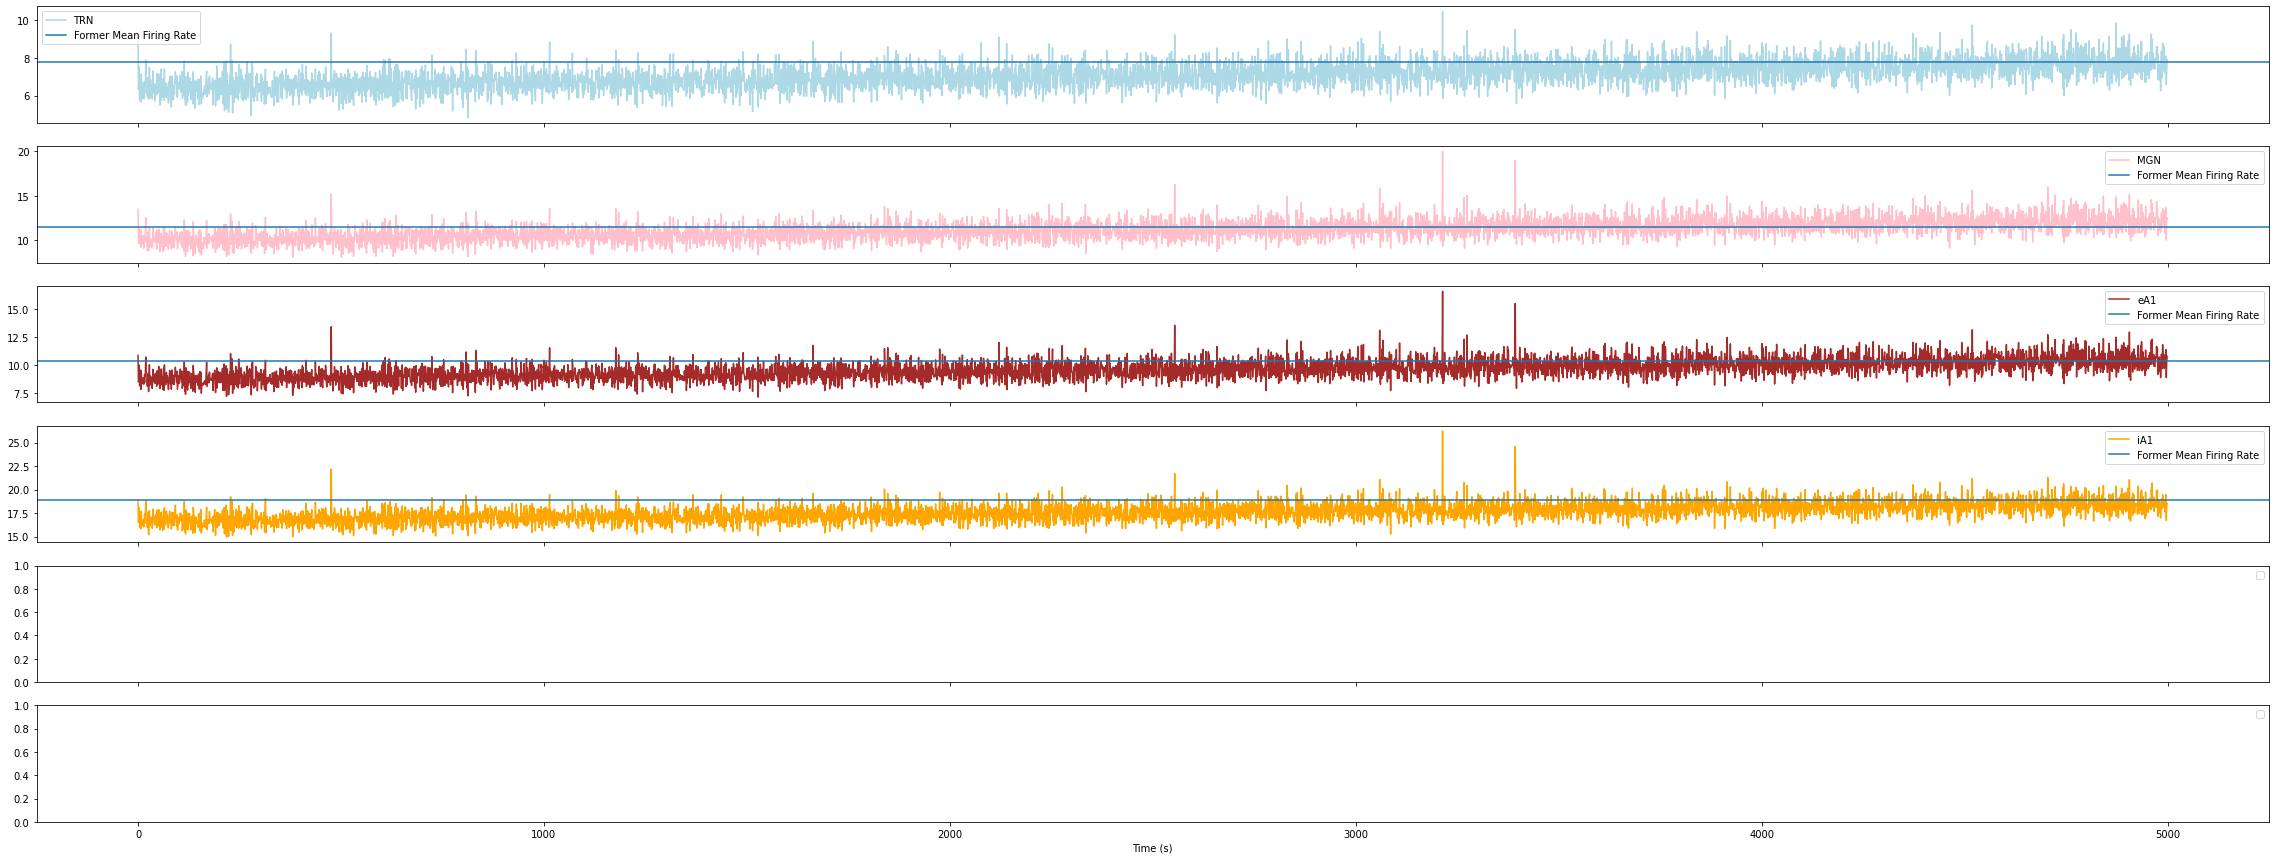

In [27]:
exp_name = '20pcdemy-15000s-eaone'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_disabled_conn_ratio=0.2_gr_scale=1e-05_update_interval=50_"

nthread = 4

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")


# DendriteType_Population
perc_mgn_eA1 = np.divide(ex_eA1, 2000*200)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(40, 15)

tstart = 0 * 1000
tstop = 5000 * 1000
    
resolution = 1000

x = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

# x_range = np.arange(400, 1401, 100)

# ax[4].plot(x_range, perc_mgn_eA1, ":", label="eA1->eA1")
# ax[4].set_ylabel("Epsilon")

# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'], label="eA1")
# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'], label="MGN")
# ax[5].axhline(.104, ls=":", label="eA1 Target")
# ax[5].axhline(.129, ls=":", label="MGN Target", color="orange")
# ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(6)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

In [153]:
conn_dfs = readnet_timeinterval("20pcdemy-15000s-eaone", 1000 * 1000, 5000 * 1000, 4, "spk_20pcdemy-15000s-eaone_disabled_conn_ratio=0.2_gr_scale=1e-05_update_interval=50_")

In [154]:
mgn_eaone_dfs = []
for df in conn_dfs:
    df = df[df.source.between(0, 200) & df.target.between(400, 2400)] # remove all connections which are not MGN->eA1
    mgn_eaone_dfs.append(df)

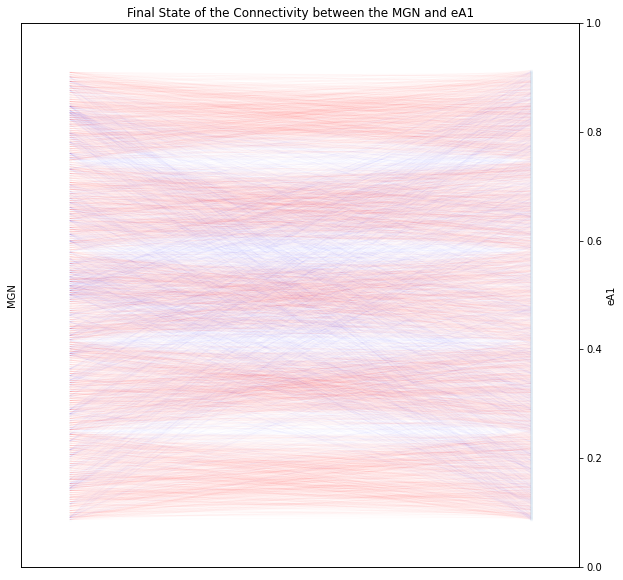

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

right_yaxis = ax.twinx()

plotConnectionGraph(mgn_eaone_dfs[-1], ax)

ax.set_title("Final State of the Connectivity between the MGN and eA1");

ax.set_ylabel("MGN")
right_yaxis.set_ylabel("eA1");

right_yaxis.set_visible("False")


## demy in eaone recurrent connections

In [177]:
perc_mgn_eA1

array([0.00769  , 0.00769  , 0.0113075, 0.0149025, 0.01788  , 0.020195 ,
       0.0220275, 0.0234175, 0.024525 , 0.0253475, 0.025925 , 0.0263225,
       0.0265375, 0.0265525, 0.02653  , 0.026535 , 0.026585 ])

In [174]:
ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

** mnist.loader ** package is not installed. To have functions using mnist.loader please install the package.
** tables ** package is not installed. To have functions using tables please install the package.


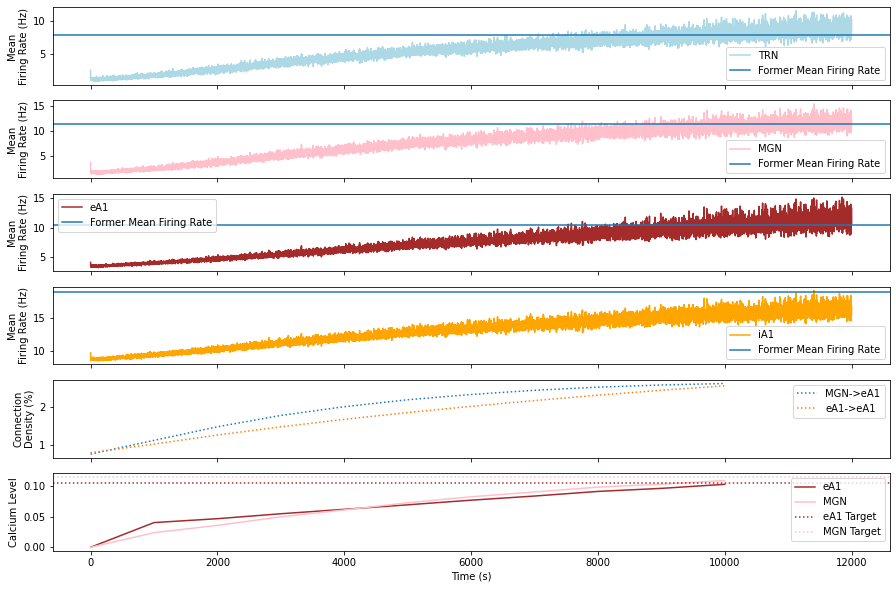

In [9]:
exp_name = 'eaone-demy-recurr'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_gr_scale=1e-05_update_interval=50_"

nthread = 48

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

# DendriteType_Population
perc_mgn_eA1 = 100 * np.divide(ex_eA1, 2000*200)
perc_recurr_eA1 = 100 * np.divide(recurr_eA1, 2000*2000)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(15, 10)

tstart = 0 * 1000
tstop = 12000 * 1000
    
resolution = 1000

x = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

[ax[_].set_ylabel("Mean\nFiring Rate (Hz)") for _ in range(4)]

x_range = np.arange(0, 11000, 1000)

ax[4].plot(x_range, perc_mgn_eA1[1:12], ":", label="MGN->eA1")
ax[4].plot(x_range, perc_recurr_eA1[1:12], ":", label="eA1->eA1")
ax[4].set_ylabel("Connection\nDensity (%)")

ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'][1:12], label="eA1", c='brown')
ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'][1:12], label="MGN", c='pink')
ax[5].axhline(.104, ls=":", label="eA1 Target", c='brown')
ax[5].axhline(.115, ls=":", label="MGN Target", color="pink")
ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(6)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

In [1]:
exp_name = 'eaone-demy-recurr'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_gr_scale=1e-05_update_interval=50_"

nthread = 48

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

# DendriteType_Population
perc_mgn_eA1 = 100 * np.divide(ex_eA1, 2000*200)
perc_recurr_eA1 = 100 * np.divide(recurr_eA1, 2000*2000)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(15, 10)

tstart = 00 * 1000
tstop = 15000 * 1000
    
resolution = 10 * 100

x = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

[ax[_].set_ylabel("Mean\nFiring Rate (Hz)") for _ in range(4)]

x_range = np.arange(0, 15001, resolution)

# ax[4].plot(x_range, perc_mgn_eA1[1:], ":", label="MGN->eA1")
# ax[4].plot(x_range, perc_recurr_eA1[1:], ":", label="eA1->eA1")
ax[4].set_ylabel("Connection\nDensity (%)")

# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'][1:], label="eA1", c='brown')
# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'][1:], label="MGN", c='pink')
ax[5].axhline(.104, ls=":", label="eA1 Target", c='brown')
ax[5].axhline(.115, ls=":", label="MGN Target", color="pink")
ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(6)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

NameError: name 'gatherNestConnectivity' is not defined

In [4]:
import pipeline as pipeline

In [8]:
tstart, tstop = 10000 * 1000, 10001 * 1000

print(
    "MFR\n",
    np.mean(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).mean_rates()),
    np.mean(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).mean_rates())
)

print(
    "STD MFR\n",
    np.std(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).mean_rates()),
    np.std(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).mean_rates())
)

resolution = 1
print(
    "STD Intantenous FR\n",
    np.std(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)),
    np.std(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True))
)

MFR
 11.445 8.465 10.85 16.118
STD MFR
 4.613780987433192 2.654952918603266 9.664548618533614 17.582720949841637
STD Intantenous FR
 8.7371025 8.289679 5.3057046 6.584078


In [10]:
print(
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop), "mit")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop), "mit"))
)

10.33552642942568 8.727510643176444 21.060496667592307 21.505765732603972


In [37]:
print(
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop), "cerina")),
    np.mean(pipeline.computePopulationBurstSpikeRatio(gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop), "cerina"))
)

3.189687974416009 1.7368131868131866 5.65608992558356 5.951609758599971


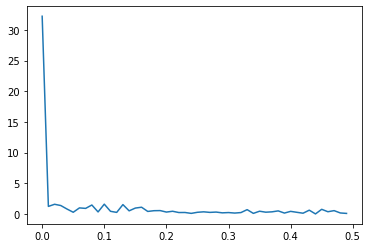

In [15]:
from scipy.fft import fft, fftfreq

ifr = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(10, average=True)
N = len(ifr)
T = 1

yf = fft(ifr)
xf = fftfreq(N, T)[:N//2]


plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

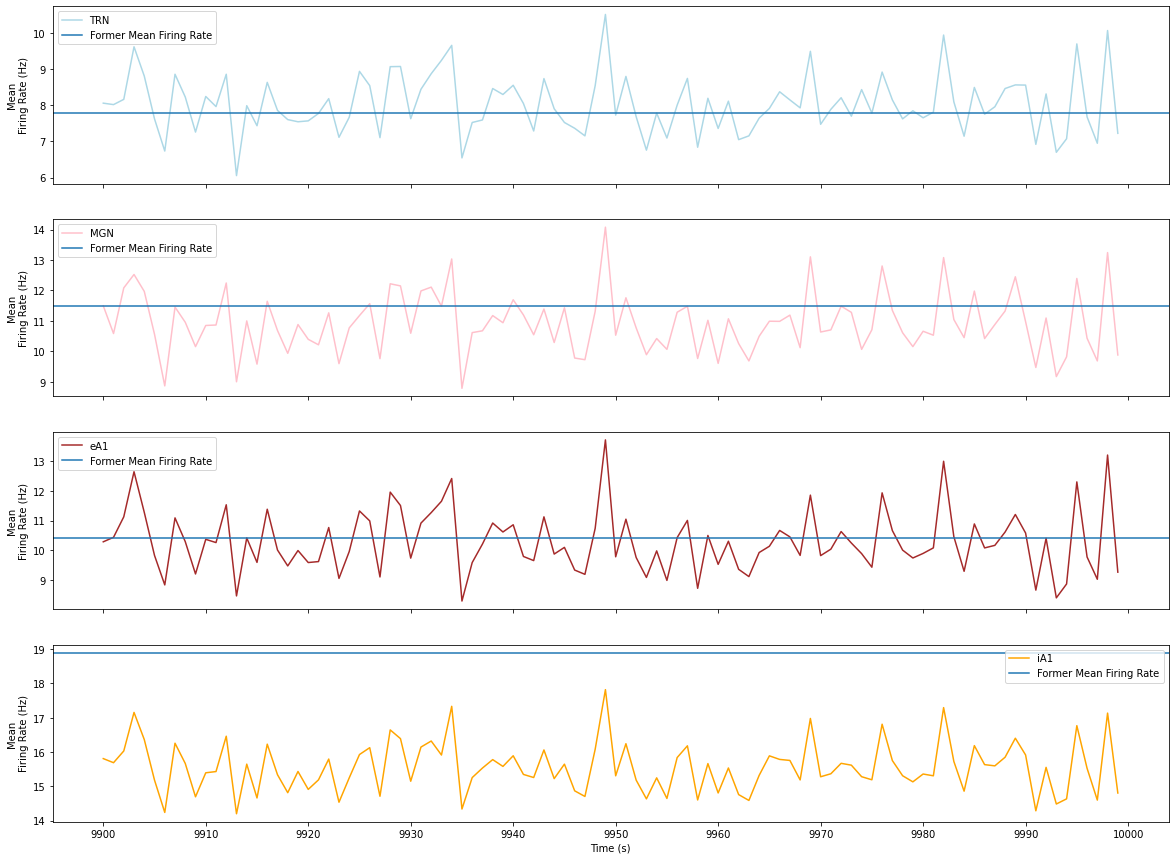

In [9]:
exp_name = 'eaone-demy-recurr'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_gr_scale=1e-05_update_interval=50_"

nthread = 48

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

# DendriteType_Population
perc_mgn_eA1 = np.divide(ex_eA1, 2000*200)
perc_recurr_eA1 = np.divide(recurr_eA1, 2000*2000)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.set_size_inches(20, 15)

tstart = 9900 * 1000
tstop = 10000 * 1000
    
resolution = 1000

x = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

[ax[_].set_ylabel("Mean\nFiring Rate (Hz)") for _ in range(4)]

x_range = np.arange(0, 11000, 1000)

# ax[4].plot(x_range, perc_mgn_eA1[1:12], ":", label="MGN->eA1")
# ax[4].plot(x_range, perc_recurr_eA1[1:12], ":", label="eA1->eA1")
# ax[4].set_ylabel("Epsilon")

# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'], label="eA1")
# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'], label="MGN")
# ax[5].axhline(.104, ls=":", label="eA1 Target")
# ax[5].axhline(.129, ls=":", label="MGN Target", color="orange")
# ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

plt.xticks(range(0, 101, 10), range( int(tstart/1000) , int(tstop/1000)+1 , 10))

[ax[_].legend() for _ in range(4)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

In [255]:
conn_dfs = readnet_timeinterval("eaone-demy-recurr", 1000 * 1000, 15000 * 1000, 48, "spk_eaone-demy-recurr_gr_scale=1e-05_update_interval=50_")

In [256]:
mgn_eaone_dfs = []
for df in conn_dfs:
    df = df[df.source.between(0, 200) & df.target.between(400, 2400)] # remove all connections which are not MGN->eA1
    mgn_eaone_dfs.append(df)

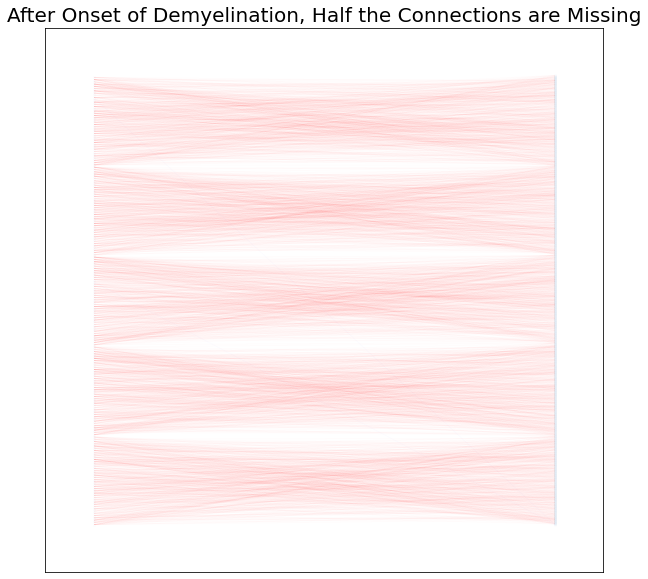

In [263]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)


plotConnectionGraph(mgn_eaone_dfs[0], ax)

ax.set_title("After Onset of Demyelination, Half the Connections are Missing", fontdict={"fontsize":20});

# ax.set_ylabel("MGN")
# right_yaxis.set_ylabel("eA1");



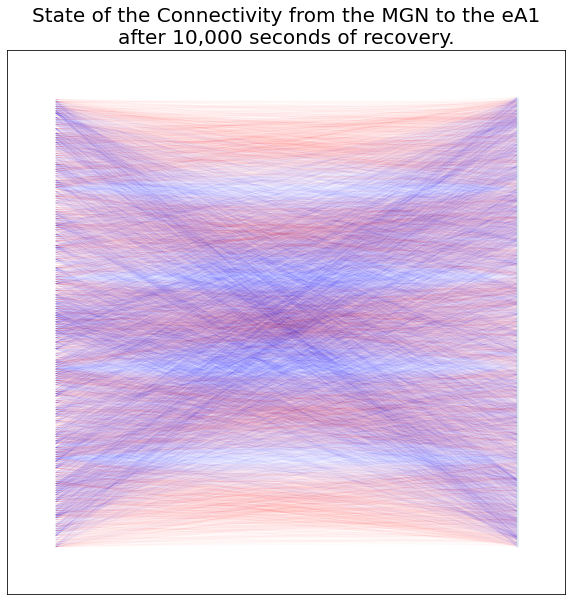

In [291]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)


plotConnectionGraph(mgn_eaone_dfs[9], ax)

ax.set_title("State of the Connectivity from the MGN to the eA1\nafter 10,000 seconds of recovery.", fontdict={"fontsize":20});

# ax.set_ylabel("MGN")
# right_yaxis.set_ylabel("eA1");



## noise demy with parrot neuron

In [194]:
recurr_eA1

array([32143, 32143, 38434, 44066, 48522, 51993, 54900, 57415, 59591,
       61544, 63366, 64997])

In [195]:
bg_eA1

array([31787, 31787, 37231, 42870, 48102, 53009, 57513, 61787, 65846,
       69748, 73452, 77019])

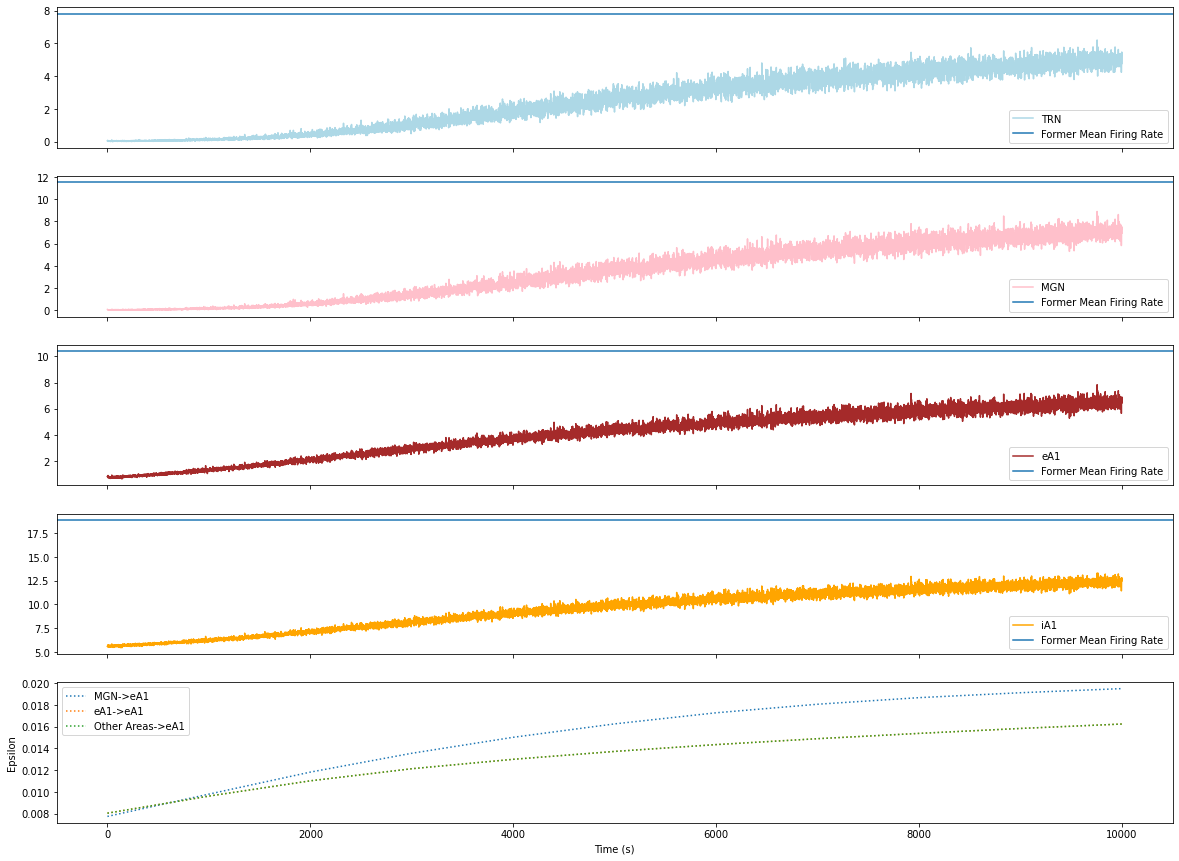

In [193]:
exp_name = 'eaone-noise-demy'
pth = "../../demyelination/data/"+exp_name+"/activity/"
fl = "spk_"+exp_name+"_gr_scale=1e-05_update_interval=50_"

nthread = 48

ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "MGN", "eA1")

recurr_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "eA1", "eA1")

bg_eA1 = gatherNestConnectivity(pth, \
             fl, \
             nthread, "parrot", "eA1")

# DendriteType_Population
perc_mgn_eA1 = np.divide(ex_eA1, 2000*200)
perc_recurr_eA1 = np.divide(recurr_eA1, 2000*2000)
perc_bg_eA1 = np.divide(bg_eA1, 2000*2000)

## Data Gathering End
## Plotting Start

fig, ax = plt.subplots(nrows=5, ncols=1, sharex=True)
fig.set_size_inches(20, 15)

tstart = 00 * 1000
tstop = 10000 * 1000
    
resolution = 1000

x = gatherSpikes(pth, fl, nthread, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(7.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(11.5, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(10.4, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, nthread, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(18.9, label="Former Mean Firing Rate")

x_range = np.arange(0, 11000, 1000)

ax[4].plot(x_range, perc_mgn_eA1[1:12], ":", label="MGN->eA1")
ax[4].plot(x_range, perc_recurr_eA1[1:12], ":", label="eA1->eA1")
ax[4].plot(x_range, perc_recurr_eA1[1:12], ":", label="Other Areas->eA1")
ax[4].set_ylabel("Epsilon")

# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['eA1'], label="eA1")
# ax[5].plot(x_range, gatherCalcium(pth, fl, nthread)['MGN'], label="MGN")
# ax[5].axhline(.104, ls=":", label="eA1 Target")
# ax[5].axhline(.129, ls=":", label="MGN Target", color="orange")
# ax[5].set_ylabel("Calcium Level")

# ax[6].plot(x_range, connectivity['z']['Axon']['in']['iA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(5)];

# plt.xlim(0, 10)
# ax[4].set_ylim(0.014, .016)

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-overshoot-calcium-slowrate-highupdate.pdf")

In [206]:
conn_dfs = readnet_timeinterval("eaone-noise-demy", 1000 * 1000, 10000 * 1000, 48, "spk_eaone-noise-demy_gr_scale=1e-05_update_interval=50_")

In [207]:
mgn_eaone_dfs = []
for df in conn_dfs:
    df = df[df.source.between(0, 200) & df.target.between(400, 2400)] # remove all connections which are not MGN->eA1
    mgn_eaone_dfs.append(df)

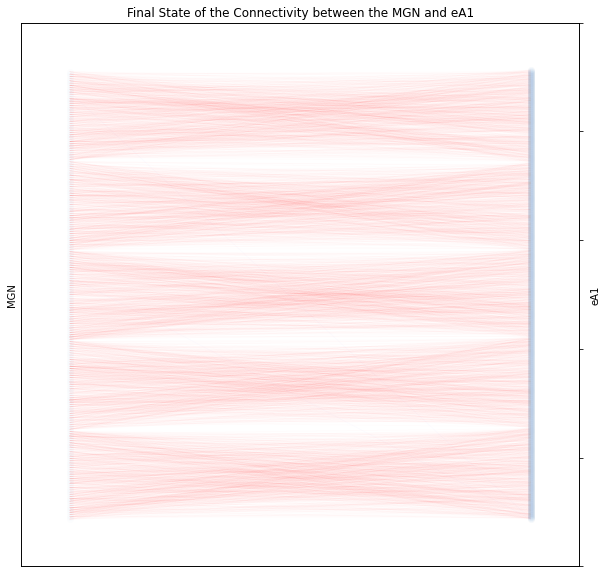

In [227]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

right_yaxis = ax.twinx()
right_yaxis.set_yticklabels([])

plotConnectionGraph(mgn_eaone_dfs[0], ax)

# ax.set_title("Final State of the Connectivity between the MGN and eA1");

ax.set_ylabel("MGN")
right_yaxis.set_ylabel("eA1");

right_yaxis.set_visible("False")
